In [1]:
# Authenticate
from remote_utils import RemoteCommunicator

remote_communicator = RemoteCommunicator()

In [2]:
# Download Data

remote_communicator.download_data()

100%|██████████| 59.8k/59.8k [00:00<00:00, 1.27MB/s]

100%|██████████| 28.0k/28.0k [00:00<00:00, 28.6MB/s]

100%|██████████| 3.18k/3.18k [00:00<00:00, 3.26MB/s]

In [3]:
# Testing cell
import sys
import importlib

print(sys.version)

3.10.8 | packaged by conda-forge | (main, Nov  4 2022, 13:42:51) [MSC v.1916 64 bit (AMD64)]


In [4]:
import numpy as np
import pandas as pd

# ML
import sklearn
import tensorflow as tf
from tensorflow import keras
import xgboost

# Hypertuning
import keras_tuner
import skopt

import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\night\miniconda3\envs\titanic_env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [5]:
# Start

train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")

gender_submission_data = pd.read_csv("../data/gender_submission.csv")

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_data.tail(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.125,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.450,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.000,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.750,NaN,Q


In [7]:
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Cabin", "Embarked"]

X = train_data[features]
X_test = test_data[features]

y = train_data["Survived"]

def tf_y(y): return y.astype(np.float64).to_numpy().reshape(-1, 1)

y_tf = tf_y(y)

X.dtypes

Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [8]:
X.describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
from sklearn.model_selection import train_test_split

val_ratio = 0.2
(X_train, X_val, y_train, y_val) = train_test_split(X, y, test_size=val_ratio)
(y_train_tf, y_val_tf) = (tf_y(y_train), tf_y(y_val))

In [10]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler#, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#using_cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

numerical_cols = ["Age", "SibSp", "Parch", "Fare"]
categorical_cols = ["Pclass", "Embarked", "Sex"]

continuous_numerical_cols = ["Age", "Fare"]
discrete_numerical_cols = ["SibSp", "Parch"]

discrete_cols = ["Pclass", "Embarked", "Sex", "SibSp", "Parch", "Cabin"] # categorical_cols + discrete_numerical_cols

#garbage_cols = ["Cabin"]


numerical_transformer = Pipeline([
    ("knn imputer", KNNImputer(n_neighbors=5)),
    ("standardizer", StandardScaler(copy=True, with_mean=True, with_std=True))
])

categorical_transformer = Pipeline([
    ("mode imputer", SimpleImputer(strategy="most_frequent")),
    ("one-hot encoder", OneHotEncoder(sparse=True, handle_unknown="ignore", dtype=np.float64))
])

preprocessor_main = ColumnTransformer([
        ("numerical pipe", numerical_transformer, numerical_cols),
        ("categorical pipe", categorical_transformer, categorical_cols)
        ], remainder="drop") # don't need to drop garbage_cols if this does it automatically



discrete_numerical_transformer = KNNImputer(n_neighbors=5)
preprocessor_venture = ColumnTransformer([
    ("continous numerical pipe", numerical_transformer, continuous_numerical_cols),
    ("discrete numerical pipe (just a knn imputer)", discrete_numerical_transformer, discrete_numerical_cols),
    ("categorical pipe", categorical_transformer, categorical_cols)
], remainder="drop") # don't need to drop garbage_cols if this does it automatically

In [11]:
def post_preprocessing_feature_names(preprocessor, X):
    preprocessor.fit_transform(X)
    return preprocessor.get_feature_names_out()

postpreprocessing_feature_names = post_preprocessing_feature_names(preprocessor_main, X_train)
postpreprocessing_venture_feature_names = post_preprocessing_feature_names(preprocessor_venture, X_train)

print(postpreprocessing_feature_names)
print(postpreprocessing_venture_feature_names)

['numerical pipe__Age' 'numerical pipe__SibSp' 'numerical pipe__Parch'
 'numerical pipe__Fare' 'categorical pipe__Pclass_1'
 'categorical pipe__Pclass_2' 'categorical pipe__Pclass_3'
 'categorical pipe__Embarked_C' 'categorical pipe__Embarked_Q'
 'categorical pipe__Embarked_S' 'categorical pipe__Sex_female'
 'categorical pipe__Sex_male']
['continous numerical pipe__Age' 'continous numerical pipe__Fare'
 'discrete numerical pipe (just a knn imputer)__SibSp'
 'discrete numerical pipe (just a knn imputer)__Parch'
 'categorical pipe__Pclass_1' 'categorical pipe__Pclass_2'
 'categorical pipe__Pclass_3' 'categorical pipe__Embarked_C'
 'categorical pipe__Embarked_Q' 'categorical pipe__Embarked_S'
 'categorical pipe__Sex_female' 'categorical pipe__Sex_male']


In [12]:
# Mutual Information
from sklearn.feature_selection import mutual_info_classif
from general_utils import alike_match
from mutual_info import organize_mi_scores, plot_mi_scores

def mi_scores_postpreprocessed(X, y, preprocessor):
    X_preprocessed = preprocessor.fit_transform(X)
    preprocessed_feature_names = preprocessor.get_feature_names_out()
    mi_scores = mutual_info_classif(X_preprocessed, y, discrete_features=alike_match(preprocessed_feature_names, discrete_cols))

    print(organize_mi_scores(mi_scores, preprocessed_feature_names))
    plot_mi_scores(mi_scores, preprocessed_feature_names)

    X_preprocessed = pd.DataFrame(X_preprocessed, columns=preprocessed_feature_names)

    return (X_preprocessed, mi_scores)

C:\Users\night\miniconda3\envs\titanic_env\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\night\miniconda3\envs\titanic_env\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


categorical pipe__Sex_female    0.150938
categorical pipe__Sex_male      0.150938
numerical pipe__Fare            0.111624
categorical pipe__Pclass_3      0.048411
numerical pipe__Age             0.040963
categorical pipe__Pclass_1      0.037376
numerical pipe__SibSp           0.020307
numerical pipe__Parch           0.016160
categorical pipe__Embarked_C    0.011029
categorical pipe__Embarked_S    0.007929
categorical pipe__Pclass_2      0.003995
categorical pipe__Embarked_Q    0.000026
Name: Mutual Info Scores, dtype: float64
     numerical pipe__Age  numerical pipe__SibSp  numerical pipe__Parch  \
0               0.569385               7.252666               2.014878   
1               0.949932              -0.490761              -0.477899   
2              -0.115601              -0.490761              -0.477899   
3               0.036618              -0.490761              -0.477899   
4               0.721604               0.477167               5.754044   
..                   ..

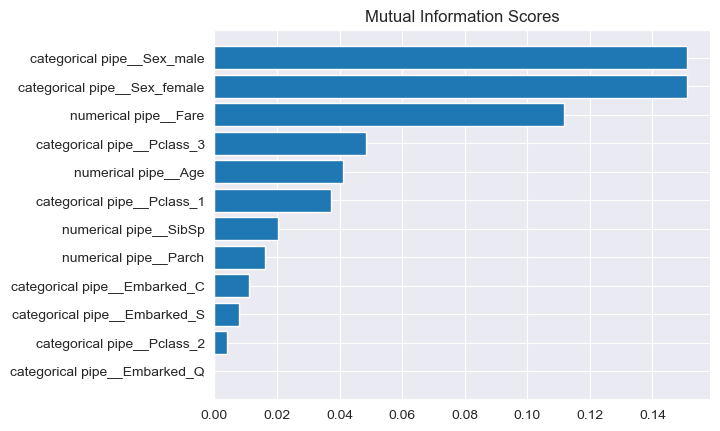

<Figure size 800x500 with 0 Axes>

In [13]:
(X_train_preprocessed, mutual_info_scores) = mi_scores_postpreprocessed(X_train, y_train, preprocessor_main)
print(X_train_preprocessed)

categorical pipe__Sex_female                           0.150938
categorical pipe__Sex_male                             0.150938
continous numerical pipe__Fare                         0.136237
continous numerical pipe__Age                          0.048526
categorical pipe__Pclass_3                             0.048411
categorical pipe__Pclass_1                             0.037376
discrete numerical pipe (just a knn imputer)__SibSp    0.020307
discrete numerical pipe (just a knn imputer)__Parch    0.016160
categorical pipe__Embarked_C                           0.011029
categorical pipe__Embarked_S                           0.007929
categorical pipe__Pclass_2                             0.003995
categorical pipe__Embarked_Q                           0.000026
Name: Mutual Info Scores, dtype: float64
     continous numerical pipe__Age  continous numerical pipe__Fare  \
0                         0.742847                        0.785126   
1                         0.941427                 

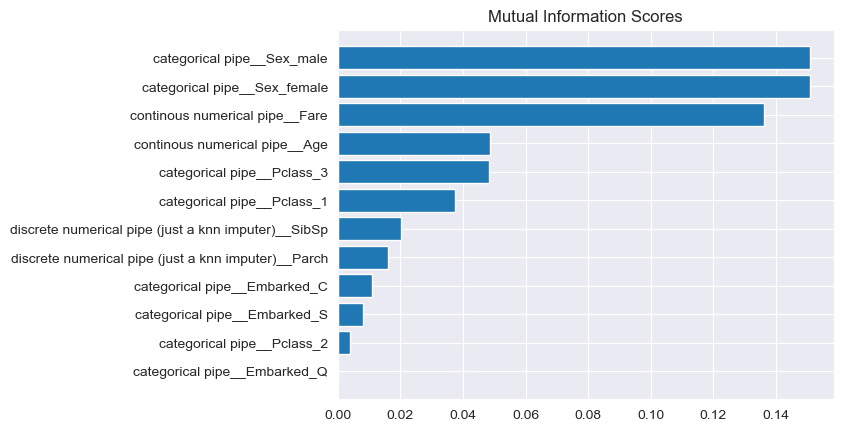

<Figure size 800x500 with 0 Axes>

In [14]:
(X_train_preprocessed_venture, mutual_info_venture_scores) = mi_scores_postpreprocessed(X_train, y_train, preprocessor_venture)
print(X_train_preprocessed_venture)

Ok, by looking at the data, we know that not scaling the discrete features does not have much of an impact on this final result

C:\Users\night\miniconda3\envs\titanic_env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


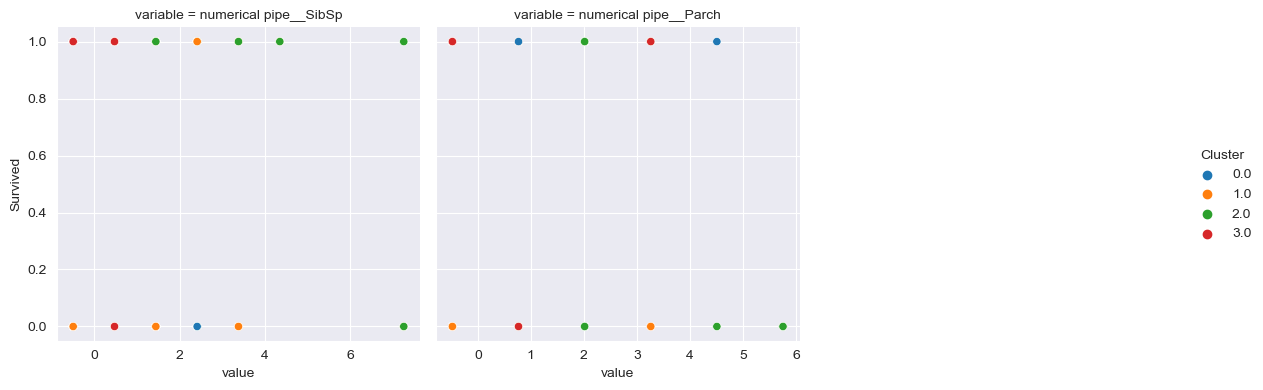

In [15]:
from sklearn.cluster import KMeans
from preprocessing_utils import AddCluster

def test_cluster(X, y, cluster_features, kmeans, cluster_name="Cluster", target_name="Target"):
    add_cluster = AddCluster(cluster_features, kmeans, cluster_name)
    X_with_cluster = add_cluster.fit_transform(X)
    X_with_cluster[cluster_name] = X_with_cluster[cluster_name].astype("category")

    X_with_cluster[target_name] = y

    actual_clusterfeatures_names = add_cluster.actual_cluster_column_names

    sns.relplot(
        x="value", y=target_name, hue=cluster_name, col="variable",
        height=4, aspect=1, facet_kws={'sharex': False}, col_wrap=3,
        data=X_with_cluster.melt(
            value_vars=actual_clusterfeatures_names, id_vars=[target_name, cluster_name]
        )
    )

cluster_features = ["SibSp", "Parch"]
kmeans = KMeans(4, n_init=10)

test_cluster(X_train_preprocessed, y_train, cluster_features, kmeans, target_name="Survived")

In [16]:
# Finalize preprocessing pipeline
from sklearn.preprocessing import FunctionTransformer
from preprocessing_utils import WrapAsDataFrame, AddCluster, AsNumPy
from preprocessing_utils import add_onehot_cluster, preprocessed_statistics

def universal_transformers(X=X_train):
    preprocessor_main.fit_transform(X)

    return [
        ("main preprocessor", preprocessor_main),
        ("pandafier", WrapAsDataFrame(feature_names=preprocessor_main.get_feature_names_out()))
    ]

def tf_transformers():
    transformers = universal_transformers()
    transformers.append(("clusterer", add_onehot_cluster(["SibSp", "Parch"], KMeans(4, n_init=10))))

    return transformers

def sk_transformers():
    transformers = universal_transformers()
    transformers.append(("clusterer", AddCluster(["SibSp", "Parch"], KMeans(4, n_init=10))))
    transformers.append(("numpifier", AsNumPy()))

    return transformers

def create_full_tf_preprocessor():
    return Pipeline(steps=tf_transformers())

def create_full_sk_preprocessor():
    return Pipeline(steps=sk_transformers())

def tf_pipeline_model(model):
    transformers = tf_transformers()
    transformers.append(("model", model))

    return Pipeline(steps=transformers)

def sk_pipeline_model(model):
    transformers = sk_transformers()
    transformers.append(("model", model))

    return Pipeline(steps=transformers)

def test_tf_preprocessor(X):
    return preprocessed_statistics(create_full_tf_preprocessor(), X)

def test_sk_preprocessor(X):
    return preprocessed_statistics(create_full_sk_preprocessor(), X)

titanic_tf_preprocessor = create_full_tf_preprocessor()
X_train_fully_preprocessed = titanic_tf_preprocessor.fit_transform(X_train)
X_val_fully_preprocessed = titanic_tf_preprocessor.transform(X_val)

titanic_sk_preprocessor = create_full_sk_preprocessor()
titanic_sk_preprocessor.fit_transform(X_train)

C:\Users\night\miniconda3\envs\titanic_env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\night\miniconda3\envs\titanic_env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\night\miniconda3\envs\titanic_env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


array([[ 0.56938451,  7.25266576,  2.0148783 , ...,  1.        ,
         0.        ,  3.        ],
       [ 0.94993211, -0.49076145, -0.47789902, ...,  0.        ,
         1.        ,  1.        ],
       [-0.11560117, -0.49076145, -0.47789902, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-1.7900106 ,  3.38095215,  2.0148783 , ...,  1.        ,
         0.        ,  3.        ],
       [ 1.33047971, -0.49076145, -0.47789902, ...,  0.        ,
         1.        ,  1.        ],
       [-0.34392973, -0.49076145, -0.47789902, ...,  0.        ,
         1.        ,  0.        ]])

## Model Plans
- use Logistic Regression, SVM SVC, Decision Tree, Random Forest, XGBoost, Keras Neural Network

## Metric Plans
- accuracy, F1 score, AUROC

In [17]:
# util imports

from dataviz import plot_learning_curve_clean, plothistory
from ml_helpers import cleanfit

from skopt import BayesSearchCV

In [18]:
X_train.shape

(712, 8)

Fitting...


C:\Users\night\miniconda3\envs\titanic_env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Plotting Learning Curve...


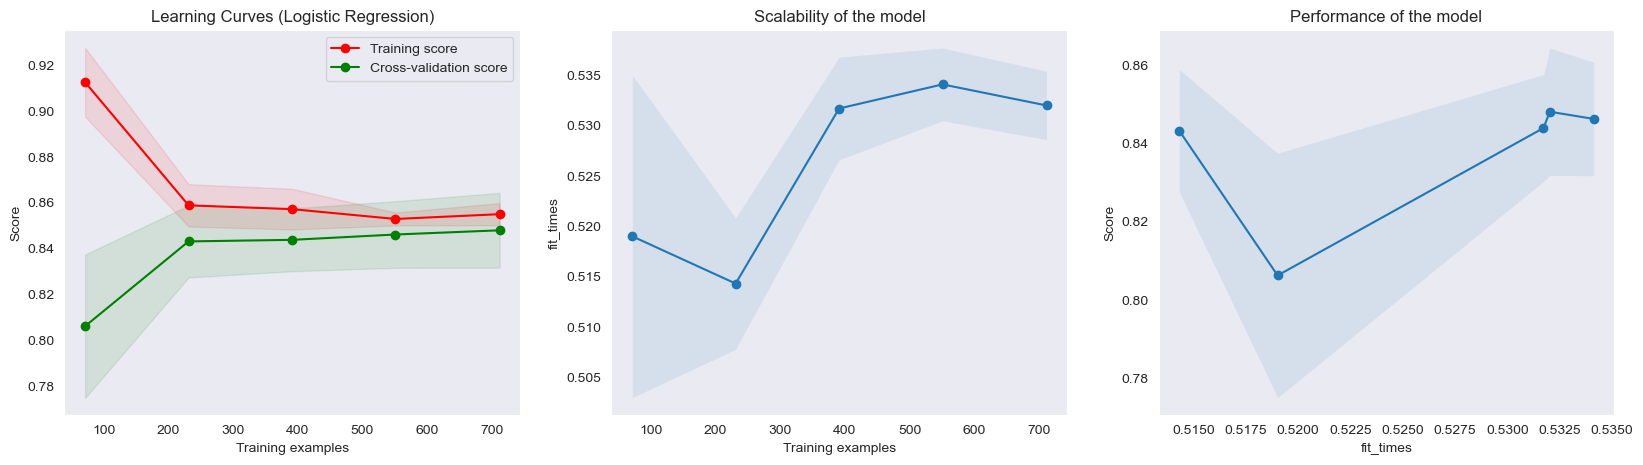

In [19]:
# LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression

logistic_regression_clf = sk_pipeline_model(LogisticRegression())

print("Fitting...")
logistic_regression_clf.fit(X_train, y_train)

print("Plotting Learning Curve...")

plot_learning_curve_clean(logistic_regression_clf,
                          "Learning Curves (Logistic Regression)",
                          X, y,
                          scoring="roc_auc")

Fitting...
val score: 0.8413895221810582
best params: OrderedDict([('model__C', 1.0), ('model__penalty', 'l1'), ('model__solver', 'liblinear')])
{'mean_fit_time': array([0.5505054 , 0.52622004, 0.53763008, 0.55332522, 0.59793768,
       0.53372626, 0.53469081, 0.57763391, 0.53612456, 0.53082142,
       0.54562926, 0.55492797, 0.52542005, 0.52644844, 0.55272231,
       0.52542272, 0.52702003, 0.52851949, 0.53142352, 0.64463658,
       0.62184262, 0.52964067, 0.52631922, 0.53152227, 0.60073624,
       0.52622032, 0.55472555, 0.51691718, 0.53235168, 0.51901832,
       0.52101855, 0.51769576, 0.52411857, 0.50831156, 0.50731459,
       0.51471624, 0.50691471, 0.50951548, 0.50751505, 0.50411429,
       0.50459828, 0.51071534, 0.50715408, 0.50711503, 0.50651488,
       0.50831537, 0.5023138 , 0.50791593, 0.50751481, 0.50931535,
       0.51051521, 0.50491428, 0.51771688, 0.51731791, 0.52131796,
       0.51371627, 0.51471653, 0.51311588, 0.51611662, 0.5095149 ,
       0.50611434, 0.5007133 , 0.

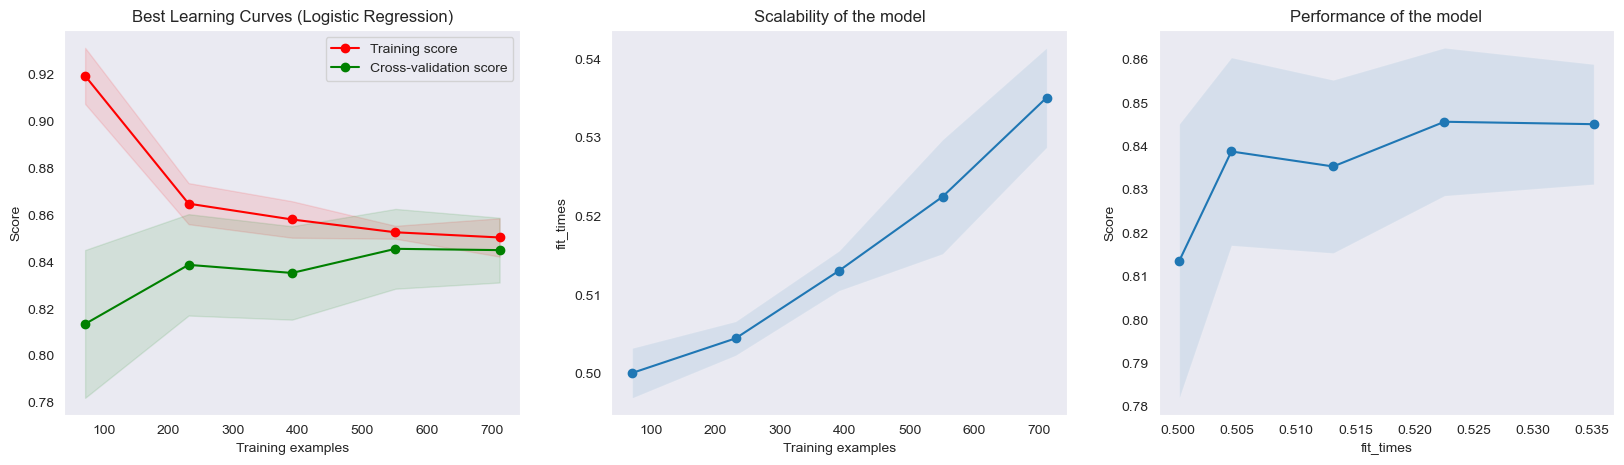

In [20]:
# HYPERTUNE LOGISTIC REGRESSION

logistic_regression_opt = BayesSearchCV(
    logistic_regression_clf,
    search_spaces=[
        {
            "model__solver": ["lbfgs"],
            "model__penalty": ["l2", "none"],
            "model__C": [0.1, 1.0, 5.0, 10.0, 100.0]
        },
        {
            "model__solver": ["liblinear"],
            "model__penalty": ["l1"],
            "model__C": [0.1, 1.0, 5.0, 10.0, 100.0]
        },
        {
            "model__solver": ["saga"],
            "model__penalty": ["elasticnet"],
            "model__l1_ratio": [0.01, 0.1, 0.5, 0.75],
            "model__C": [0.1, 1.0, 5.0, 10.0, 100.0]
        }
    ],
    scoring="roc_auc"
)

print("Fitting...")
cleanfit(logistic_regression_opt, X_train, y_train)

best_logistic_regression_clf = logistic_regression_opt.best_estimator_
print(f"val score: {logistic_regression_opt.best_score_}")
print(f"best params: {logistic_regression_opt.best_params_}")
print(logistic_regression_opt.cv_results_); print()

print("Plotting learning curves...")
plot_learning_curve_clean(best_logistic_regression_clf,
                          "Best Learning Curves (Logistic Regression)",
                          X, y,
                          scoring="roc_auc")

Fitting...
Plotting Learning Curve...


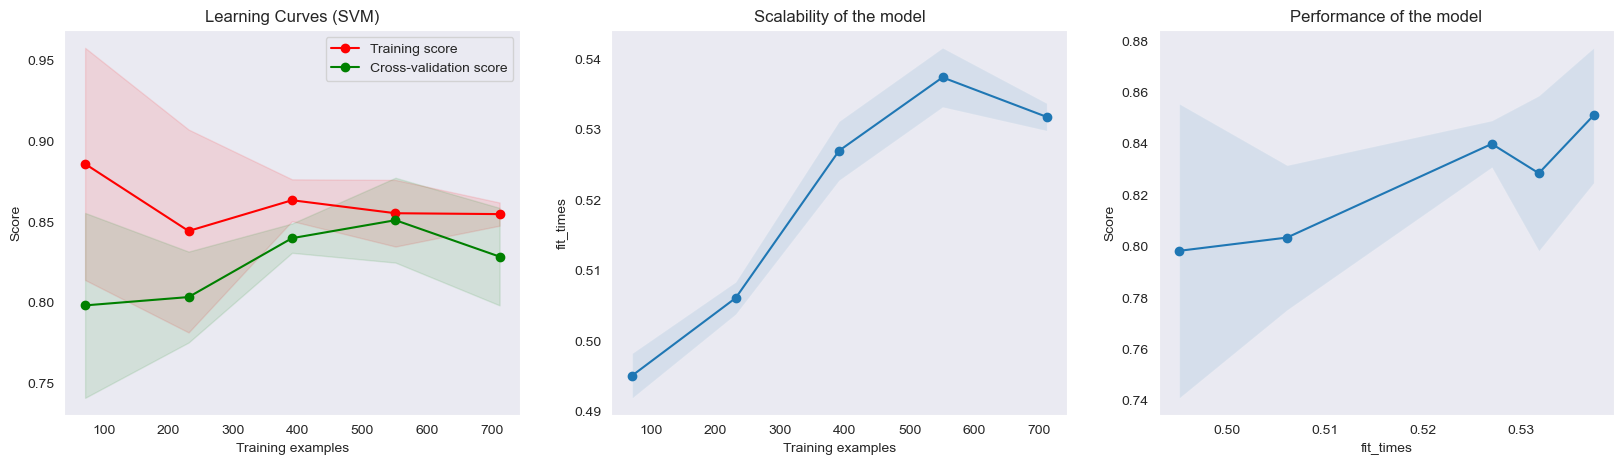

In [21]:
# SVM
from sklearn.svm import SVC

svm_clf = sk_pipeline_model(SVC(kernel="rbf"))

print("Fitting...")
cleanfit(svm_clf, X_train, y_train)

print("Plotting Learning Curve...")
plot_learning_curve_clean(svm_clf,
                          "Learning Curves (SVM)",
                          X, y,
                          scoring="roc_auc")

Fitting...
val score: 0.8472131186472879
best params: OrderedDict([('model__C', 1.0), ('model__kernel', 'rbf')])
{'mean_fit_time': array([0.52151771, 0.54512339, 0.54752364, 0.5473237 , 0.52951937,
       0.5323205 , 0.53392067, 0.53199935, 0.53332067, 0.52551885,
       0.52271805, 0.52031751, 0.51971745, 0.5224184 , 0.52261877,
       0.52231784, 0.52171783, 0.52211833, 0.52591958, 0.52151804,
       0.52211814, 0.5244113 , 0.52361908, 0.52731915, 0.52171764,
       0.52231779, 0.52221022, 0.52761984, 0.51751685, 0.5209177 ,
       0.52811975, 0.52411857, 0.5211175 , 0.526719  , 0.52431822,
       0.52271814, 0.51971712, 0.52031755, 0.52061834, 0.52091761,
       0.52011738, 0.52111764, 0.52151771, 0.522118  , 0.52491846,
       0.52251816, 0.52211781, 0.52191806, 0.52071748, 0.52101893,
       0.52691889, 0.54012246, 0.53852153, 0.55712595, 0.54032202,
       0.54022307, 0.53612151, 0.54212308, 0.55972657, 0.59673505,
       0.5951345 , 0.52511854, 0.5313201 , 0.52611938, 0.52551866

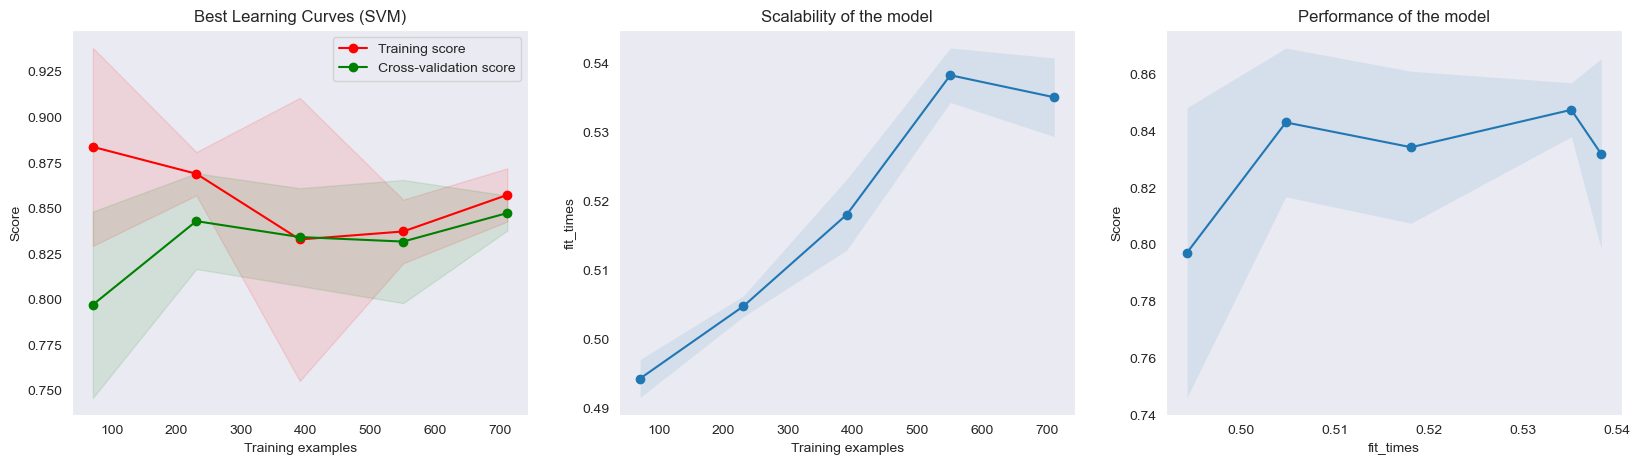

In [22]:
# HYPERTUNE SVM

svm_opt = BayesSearchCV(
    svm_clf,
    search_spaces=[
        {
            "model__kernel": ["rbf"],
            "model__C": [0.1, 1.0, 10.0, 100.0]
        },
        {
            "model__kernel": ["poly"],
            "model__degree": [3, 5, 7],
            "model__C": [0.1, 1.0, 10.0, 100.0]
        }
    ],
    scoring="roc_auc"
)

print("Fitting...")
cleanfit(svm_opt, X_train, y_train)

best_svm_clf = svm_opt.best_estimator_
print(f"val score: {svm_opt.best_score_}")
print(f"best params: {svm_opt.best_params_}")
print(svm_opt.cv_results_); print()

print("Plotting learning curves...")
plot_learning_curve_clean(best_svm_clf,
                          "Best Learning Curves (SVM)",
                          X, y,
                          scoring="roc_auc")

Fitting...
Plotting Learning Curve...


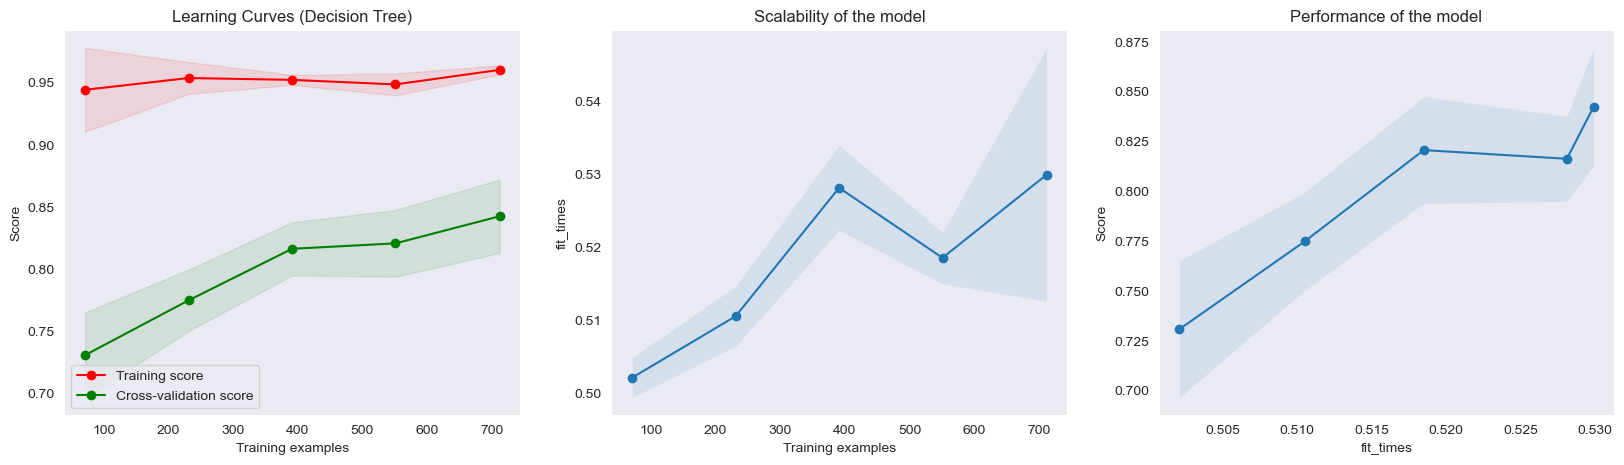

In [23]:
# DECISION TREE
from sklearn.tree import DecisionTreeClassifier

decisiontree_clf = sk_pipeline_model(DecisionTreeClassifier(criterion="gini", min_samples_leaf=5))

print("Fitting...")
cleanfit(decisiontree_clf, X_train, y_train)

print("Plotting Learning Curve...")
plot_learning_curve_clean(decisiontree_clf,
                    "Learning Curves (Decision Tree)",
                    X, y,
                    scoring="roc_auc")

Fitting...
val score: 0.8398662961907476
best params: OrderedDict([('model__criterion', 'entropy'), ('model__max_depth', 3), ('model__min_samples_leaf', 1)])
{'mean_fit_time': array([0.51731696, 0.5221189 , 0.52271824, 0.52591887, 0.5231184 ,
       0.5217113 , 0.52351837, 0.52071815, 0.52311835, 0.5159164 ,
       0.52030425, 0.51131568, 0.5145164 , 0.51091547, 0.50861635,
       0.5111155 , 0.5191174 , 0.51911955, 0.51691875, 0.51651664,
       0.51771708, 0.51431642, 0.51431646, 0.52141876, 0.51451826,
       0.53462281, 0.52391829, 0.52171788, 0.52031755, 0.52051773,
       0.52071748, 0.51251602, 0.51531677, 0.51541739, 0.51720924,
       0.51381683, 0.51671681, 0.51791697, 0.51731715, 0.51875758,
       0.51431661, 0.51311617, 0.51271596, 0.52842331, 0.52811947,
       0.52811956, 0.51951752, 0.51691685, 0.51151686, 0.51391621]), 'std_fit_time': array([0.01982781, 0.00547987, 0.00653151, 0.01514807, 0.0076437 ,
       0.01136641, 0.00471714, 0.00694705, 0.00858133, 0.0147193 ,
  

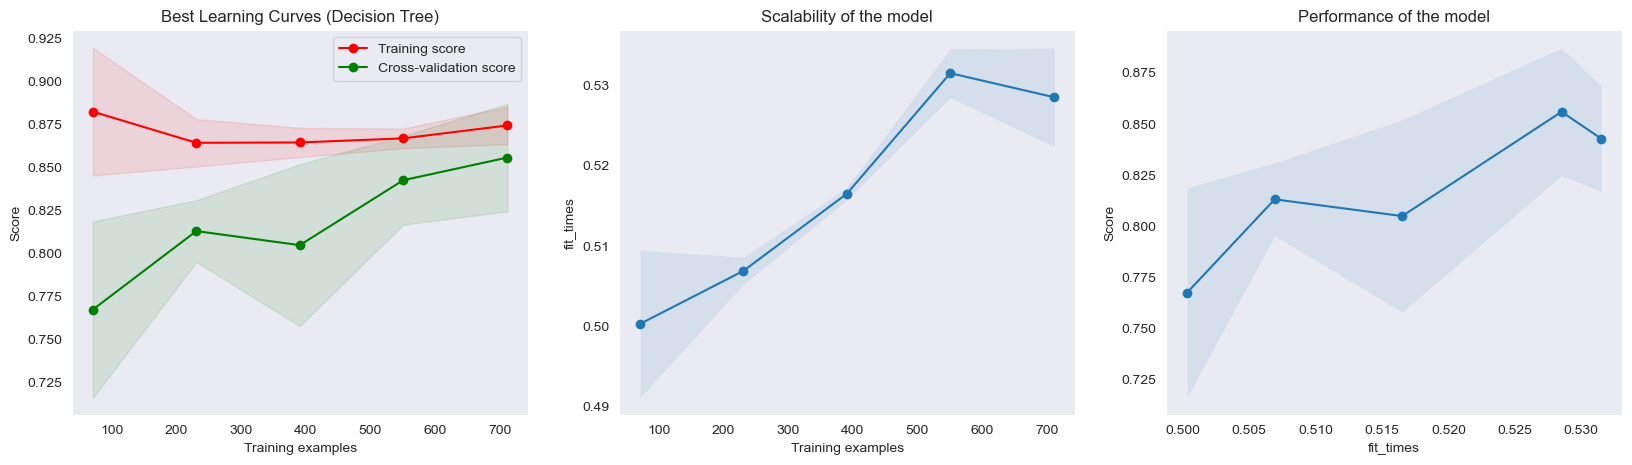

In [24]:
# HYPERTUNE DECISION TREE
decisiontree_opt = BayesSearchCV(
    decisiontree_clf,
    search_spaces={
        "model__criterion": ["gini", "entropy"],
        "model__max_depth": [None, 3, 20],
        "model__min_samples_leaf": [1, 10, 25, 50]
    },
    scoring="roc_auc"
)

print("Fitting...")
cleanfit(decisiontree_opt, X_train, y_train)

best_decisiontree_clf = decisiontree_opt.best_estimator_
print(f"val score: {decisiontree_opt.best_score_}")
print(f"best params: {decisiontree_opt.best_params_}")
print(decisiontree_opt.cv_results_); print()

print("Plotting learning curves...")
plot_learning_curve_clean(best_decisiontree_clf,
                          "Best Learning Curves (Decision Tree)",
                          X, y,
                          scoring="roc_auc")

Fitting...
Plotting Learning Curve...


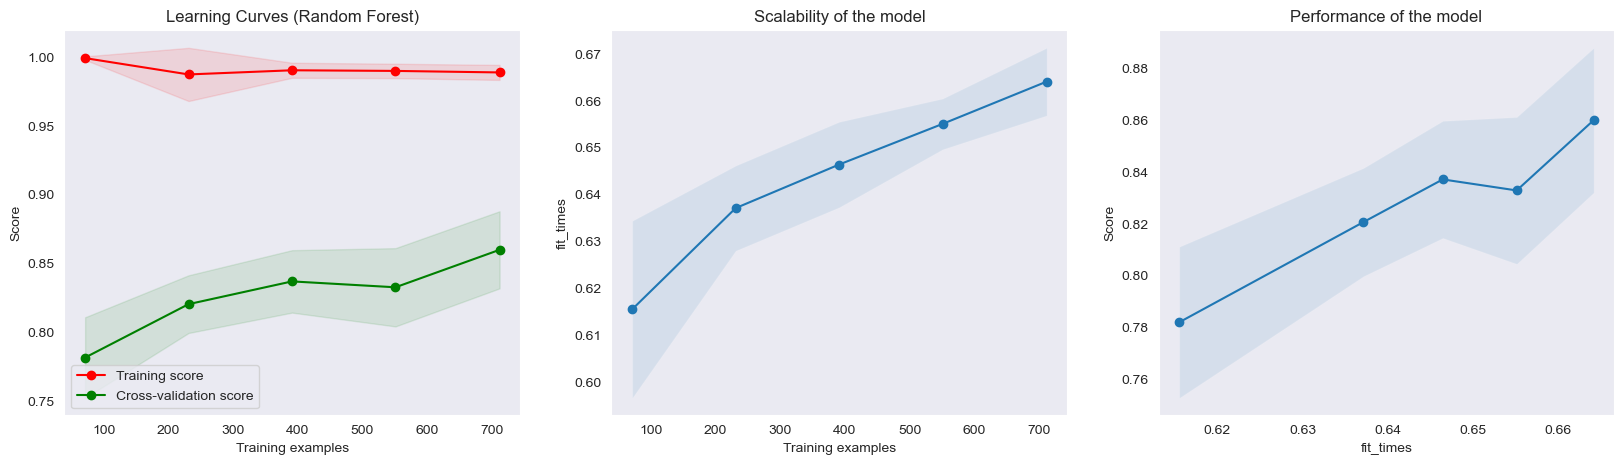

In [25]:
# RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier

rf_clf = sk_pipeline_model(RandomForestClassifier(n_estimators=100, criterion="gini"))

print("Fitting...")
cleanfit(rf_clf, X_train, y_train)

print("Plotting Learning Curve...")
plot_learning_curve_clean(rf_clf,
                          "Learning Curves (Random Forest)",
                          X, y,
                          scoring="roc_auc")

Fitting...
val score: 0.863810677305975
best params: OrderedDict([('model__bootstrap', False), ('model__criterion', 'gini'), ('model__max_depth', 5), ('model__n_estimators', 512)])
{'mean_fit_time': array([1.00202732, 1.03170595, 0.77860503, 0.58113184, 0.60833769,
       0.6475553 , 0.59213405, 0.58603349, 0.58513222, 0.64764776,
       0.7355669 , 0.91240683, 0.77957773, 0.73106685, 0.90601749,
       0.99290371, 0.65943742, 0.67655377, 0.59916015, 1.03698158,
       0.59113369, 0.63914471, 0.63978996, 0.72695479, 0.90300474,
       0.89760389, 0.90380578, 0.73236694, 0.92000861, 0.73236642,
       0.79578028, 0.58193197, 0.63794551, 0.78988037, 0.64194484,
       0.67395315, 0.63694386, 0.73337822, 0.59253407, 0.91300697,
       0.64374552, 0.635144  , 0.58434067, 0.72576499, 0.91924291,
       0.90120463, 0.64174547, 0.66055007, 0.73656697, 0.63734508,
       0.67915406, 0.60362792, 0.67305365, 0.61093822, 0.80898414,
       0.60636773, 0.69235716, 0.78757935, 0.68275547, 0.6767534

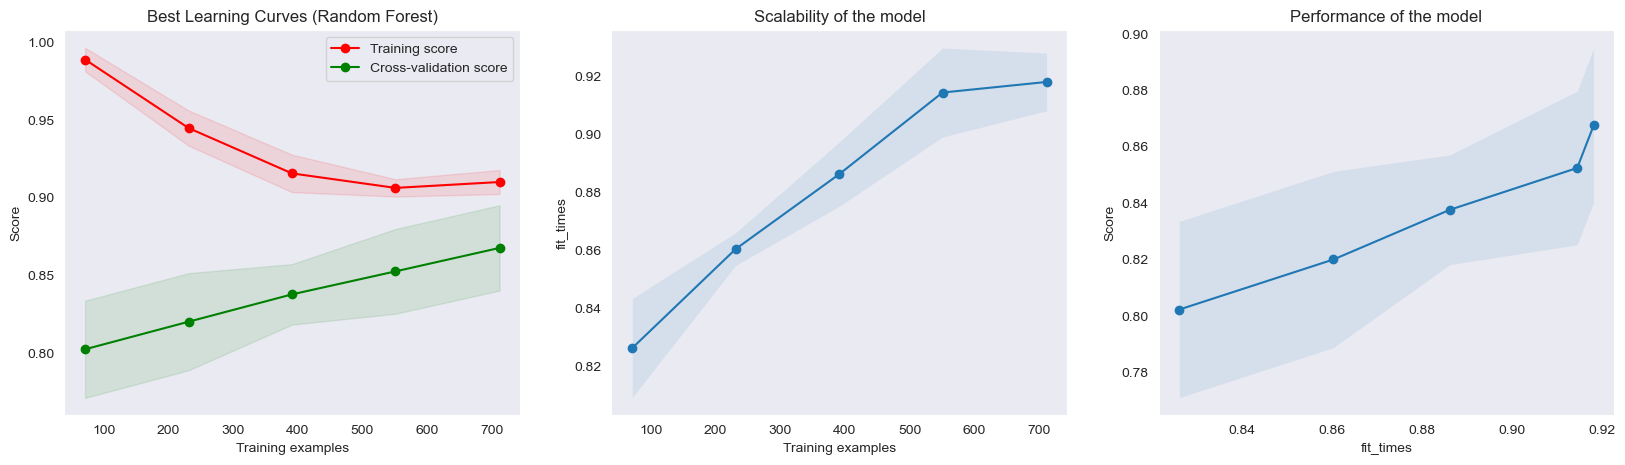

In [26]:
# HYPERTUNE RANDOM FOREST
rf_opt = BayesSearchCV(
    rf_clf,
    search_spaces=[
        {
            "model__n_estimators": [64, 128, 256, 512],
            "model__criterion": ["gini", "entropy"],
            "model__max_depth": [None, 5, 15],
            "model__bootstrap": [False]
        },
        {
            "model__n_estimators": [64, 128, 256, 512],
            "model__criterion": ["gini", "entropy"],
            "model__max_depth": [None, 5, 15],
            "model__bootstrap": [True]
        }
    ],
    scoring="roc_auc"
)

print("Fitting...")
cleanfit(rf_opt, X_train, y_train)

best_rf_clf = rf_opt.best_estimator_
print(f"val score: {rf_opt.best_score_}")
print(f"best params: {rf_opt.best_params_}")
print(rf_opt.cv_results_); print()

print("Plotting learning curves...")
plot_learning_curve_clean(best_rf_clf,
                          "Best Learning Curves (Random Forest)",
                          X, y,
                          scoring="roc_auc")

Fitting...
[03:17:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Plotting Learning Curve...
[03:17:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:17:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore

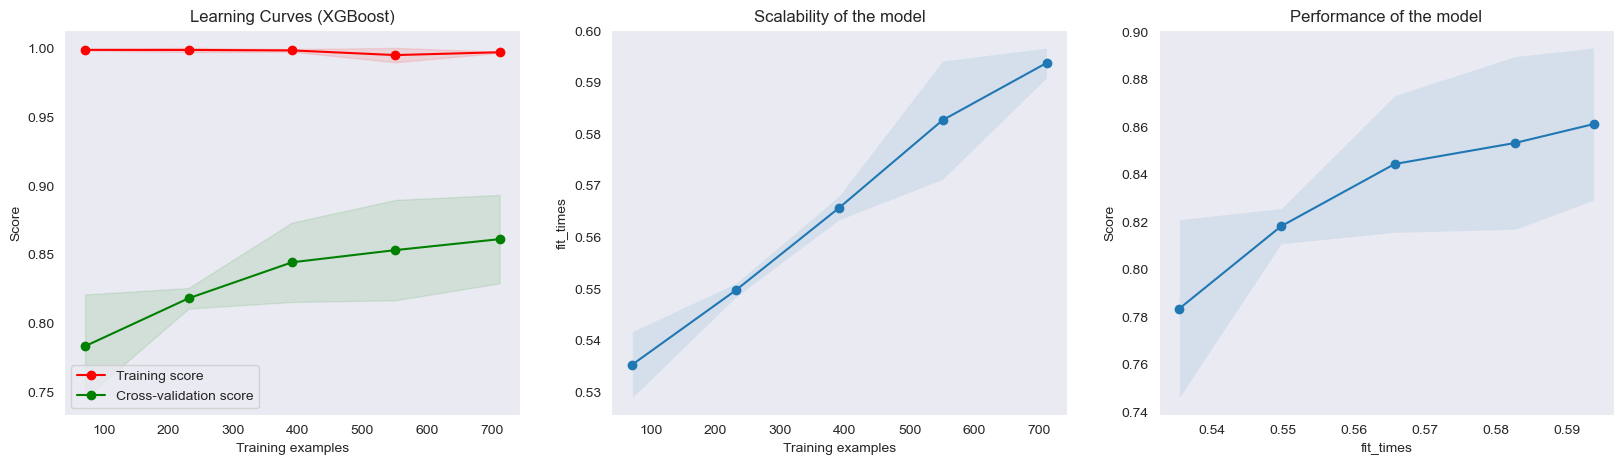

In [27]:
# BOOSTED TREE ENSEMBLE: XGBOOST
from xgboost import XGBClassifier

xgb_clf = sk_pipeline_model(XGBClassifier(n_estimators=100))

print("Fitting...")
cleanfit(xgb_clf, X_train, y_train)

print("Plotting Learning Curve...")
plot_learning_curve_clean(xgb_clf,
                          "Learning Curves (XGBoost)",
                          X, y,
                          scoring="roc_auc")

Fitting...
[03:18:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:18:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:18:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with 

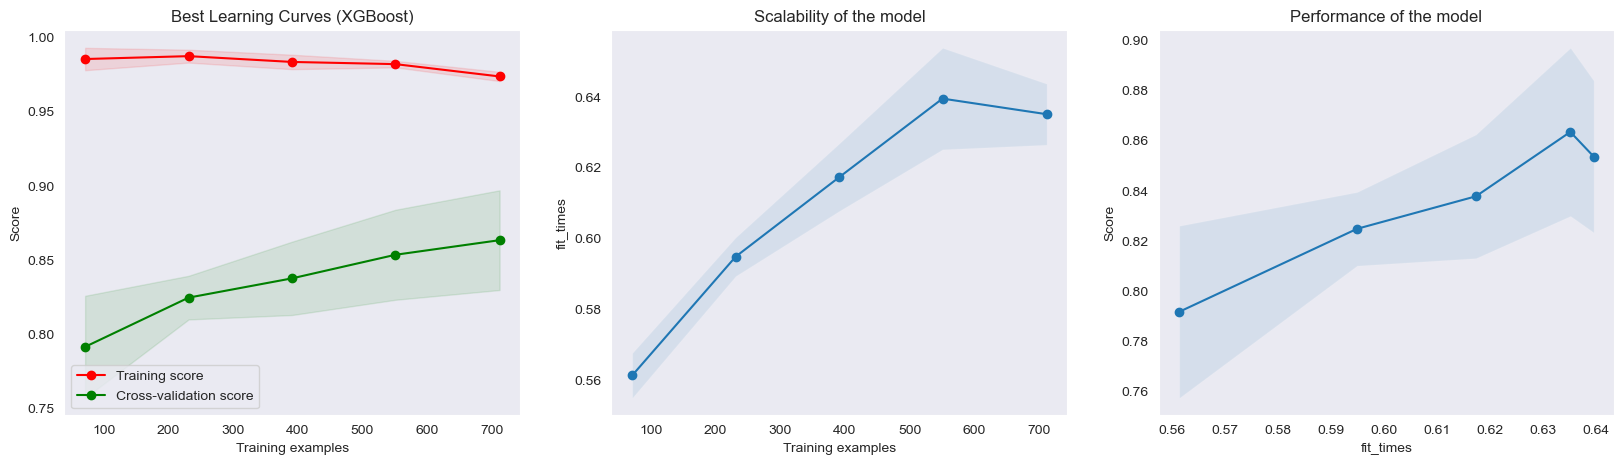

In [28]:
from sklearn.metrics import roc_auc_score

# HYPERTUNE XGBOOST
xgb_opt = BayesSearchCV(
    xgb_clf,
    search_spaces=[
        {
            "model__n_estimators": [50, 75, 128, 200],
            "model__learning_rate": [0.1, 0.5, 1.0],
            "model__gamma": [0.1, 0.59],
            "model__max_depth": [6, 16, 37],
            "model__eval_metric": [roc_auc_score],
            "model__early_stopping_rounds": [10]
        }
    ],
    fit_params={
        "model__eval_set": (X_val, y_val)
    },
    scoring="roc_auc",
    return_train_score=True
)

print("Fitting...")
cleanfit(xgb_opt, X_train, y_train)

best_xgb_clf = xgb_opt.best_estimator_
print(f"val score: {xgb_opt.best_score_}")
print(f"best params: {xgb_opt.best_params_}")
print(xgb_opt.cv_results_); print()

print("Plotting learning curves...")
plot_learning_curve_clean(best_xgb_clf,
                          "Best Learning Curves (XGBoost)",
                          X, y,
                          scoring="roc_auc")

In [29]:
(X_train_, shape, dtype) = test_tf_preprocessor(X_train)
num_features = shape[1]

del X_train_
del shape
del dtype

calling preprocessor.fit_transform()


C:\Users\night\miniconda3\envs\titanic_env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Transformation complete.
type: <class 'numpy.ndarray'>
shape: (712, 16)
dtype: float64


Fitting...
Epoch 1/700
1/1 [==============================] - 1s 1s/step - loss: 20.5545 - auc_8: 0.3122 - val_loss: 20.2687 - val_auc_8: 0.6243
Epoch 2/700
1/1 [==============================] - 0s 26ms/step - loss: 20.3219 - auc_8: 0.5107 - val_loss: 20.2016 - val_auc_8: 0.6916
Epoch 3/700
1/1 [==============================] - 0s 28ms/step - loss: 20.1420 - auc_8: 0.6639 - val_loss: 20.1301 - val_auc_8: 0.7355
Epoch 4/700
1/1 [==============================] - 0s 28ms/step - loss: 19.9991 - auc_8: 0.7619 - val_loss: 20.0549 - val_auc_8: 0.7710
Epoch 5/700
1/1 [==============================] - 0s 27ms/step - loss: 19.8800 - auc_8: 0.8143 - val_loss: 19.9764 - val_auc_8: 0.8068
Epoch 6/700
1/1 [==============================] - 0s 29ms/step - loss: 19.7745 - auc_8: 0.8350 - val_loss: 19.8951 - val_auc_8: 0.8146
Epoch 7/700
1/1 [==============================] - 0s 28ms/step - loss: 19.6761 - auc_8: 0.8484 - val_loss: 19.8113 - val_auc_8: 0.8315
Epoch 8/700
1/1 [======================

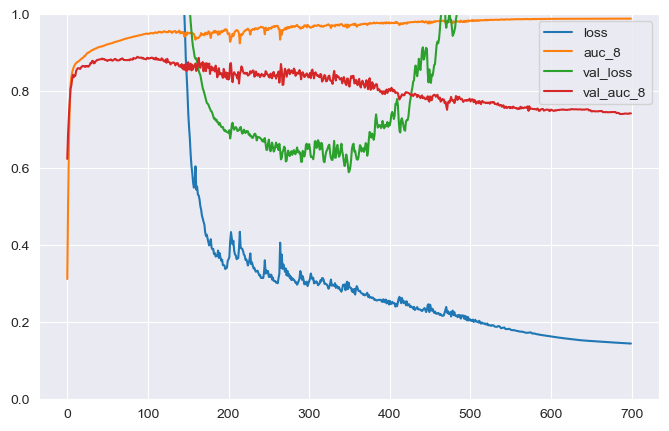

In [113]:
# NEURAL NETWORK
import math
import scikeras
from scikeras.wrappers import KerasClassifier
from keras import Sequential
from keras.layers import Input, Dense, Activation, BatchNormalization, Reshape, AlphaDropout, PReLU
from keras.losses import BinaryCrossentropy
from keras.metrics import AUC, BinaryAccuracy, Precision, Recall
from keras.callbacks import EarlyStopping, LearningRateScheduler
from dataviz import plothistory
from learning_rate_schedulers import OneCycleScheduler

class MCFriendly_Dropout(AlphaDropout):
    def call(self, inputs, **kwargs):
        return super().call(inputs, training=True)



def init_nn_model():
    seq_nn_clf = Sequential([
        Input(shape=(num_features,)),
        Reshape(target_shape=(1, -1)), # turn x into a column vector

        BatchNormalization(),

        Dense(175, kernel_initializer="lecun_normal"),
        Activation("selu"),

        Dense(120, kernel_initializer="lecun_normal"),
        Activation("selu"),
        MCFriendly_Dropout(rate=0.025),

        Dense(120, kernel_initializer="lecun_normal", kernel_regularizer="l1"),
        Activation("selu"),
        MCFriendly_Dropout(rate=0.025),

        Dense(120, kernel_initializer="lecun_normal", kernel_regularizer="l1"),
        Activation("selu"),
        MCFriendly_Dropout(rate=0.025),

        Dense(100, kernel_initializer="lecun_normal", kernel_regularizer="l1"),
        Activation("selu"),

        Dense(1, activation="sigmoid")
    ])

    lr = 0.0001
    max_lr = 0.0025

    seq_nn_clf.compile(loss=BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                       metrics=[AUC(curve="ROC")#,
                                #BinaryAccuracy(), Precision(), Recall()
    ])

    m_train = len(X_train)

    n_epochs = 700
    minibatch_size = m_train

    n_iter = math.ceil(m_train / minibatch_size) * n_epochs

    sk_keras = KerasClassifier(model=seq_nn_clf,
                               batch_size=minibatch_size, epochs=n_epochs,
                               callbacks=[
                                   EarlyStopping(patience=30, restore_best_weights=True),
                                   OneCycleScheduler(iterations=n_iter, max_rate=max_lr)
                               ]
    )

    sk_keras.set_params(fit__validation_data=(X_val_fully_preprocessed, y_val_tf))

    return sk_keras

def init_nn_model2():
    seq_nn_clf = Sequential([
        Input(shape=(num_features,)),
        Reshape(target_shape=(1, -1)), # turn x into a column vector

        BatchNormalization(),

        Dense(300, kernel_initializer="glorot_uniform", use_bias=False),
        BatchNormalization(),
        PReLU(),

        Dense(200, kernel_initializer="glorot_uniform"),
        Activation("swish"),

        Dense(200, kernel_initializer="glorot_uniform"),
        Activation("swish"),

        Dense(150, kernel_initializer="glorot_uniform", kernel_regularizer="l1"),
        BatchNormalization(),
        PReLU(),

        Dense(1, activation="sigmoid")
    ])

    lr = 0.0001
    max_lr = 0.0025

    seq_nn_clf.compile(loss=BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                       metrics=[AUC(curve="ROC")#,
                                #BinaryAccuracy(), Precision(), Recall()
                                ])

    m_train = len(X_train)

    n_epochs = 700
    minibatch_size = m_train

    n_iter = math.ceil(m_train / minibatch_size) * n_epochs

    sk_keras = KerasClassifier(model=seq_nn_clf,
                               batch_size=minibatch_size, epochs=n_epochs,
                               callbacks=[
                                   #EarlyStopping(patience=30, restore_best_weights=True),
                                   OneCycleScheduler(iterations=n_iter, max_rate=max_lr)])

    sk_keras.set_params(fit__validation_data=(X_val_fully_preprocessed, y_val_tf))

    return sk_keras

nn = init_nn_model2()
nn_clf = tf_pipeline_model(nn)

print("Fitting...")

cleanfit(nn_clf, X_train, y_train_tf)

plothistory(nn.history_)

In [101]:
from sklearn.metrics import log_loss as binary_crossentropy
import warnings

# score models
def score(model, X=X_val, y=y_val):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        yhat = model.predict(X)

    return roc_auc_score(y, yhat)

def error(model, X=X_val, y=y_val):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        yhat = model.predict(X)

    return binary_crossentropy(y, yhat)

def tf_error(model, X=X_val, y=y_val_tf):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        yhat = model.predict(X)

    return keras.metrics.binary_crossentropy(y, yhat)

print(f"Logistic Regression: score = {score(logistic_regression_clf)}, error = {error(logistic_regression_clf)}")
print(f"SVM: score = {score(svm_clf)}, error = {error(svm_clf)}")
print(f"Decision Tree: score = {score(decisiontree_clf)}, error = {error(decisiontree_clf)}")
print(f"Random Forest: score = {score(rf_clf)}, error = {error(rf_clf)}")
print(f"XGBoost: score = {score(xgb_clf)}, error = {error(xgb_clf)}")
print(f"Neural Network: score = {score(nn_clf)}, error = {tf_error(nn_clf)}")

print()

print(f"Best Logistic Regression: score = {score(best_logistic_regression_clf)}, error = {error(best_logistic_regression_clf)}")
print(f"Best SVM: score = {score(best_svm_clf)}, error = {error(best_svm_clf)}")
print(f"Best Decision Tree: score = {score(best_decisiontree_clf)}, error = {error(best_decisiontree_clf)}")
print(f"Best Random Forest: score = {score(best_rf_clf)}, error = {error(best_rf_clf)}")
print(f"Best XGBoost: score = {score(best_xgb_clf)}, error = {error(best_xgb_clf)}")

Logistic Regression: score = 0.7792510660980811, error = 6.174574528555553
SVM: score = 0.823960554371002, error = 5.2097863700959195
Decision Tree: score = 0.7703224946695095, error = 6.9464041619183075
Random Forest: score = 0.7763192963752665, error = 6.75345903789568
XGBoost: score = 0.8196295309168443, error = 5.402771697341294
1/1 [==============================] - 0s 16ms/step
Neural Network: score = 0.747934434968017, error = [ 0.          0.          0.         15.42494847 15.42494847  0.
  0.          0.         15.42494847  0.          0.          0.
 15.42494847  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         15.42494847
  0.          0.          0.          0.          0.          0.
 15.42494847  0.          0.          0.         15.42494847  0.
  0.         15.42494847 15.424948

In [79]:
from ml_helpers import ModelComparator

xgb_comparator = ModelComparator(score_func=score, error_func=error,
                             X_train=X_train, y_train=y_train,
                             X_val=X_val, y_val=y_val)

svm_comparator = ModelComparator(score_func=score, error_func=error,
                                 X_train=X_train, y_train=y_train,
                                 X_val=X_val, y_val=y_val)

In [99]:
# Chosen model type: xgboost, svm
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model_xgb = sk_pipeline_model(XGBClassifier(
        n_estimators=125,
        learning_rate=0.3,
        reg_alpha=2.0,
        grow_policy='depthwise'
    ))

    model_xgb.fit(X_train, y_train)

    model_svm = sk_pipeline_model(SVC(
        kernel="rbf",
        class_weight="balanced",
        gamma="scale"
    ))

    model_svm.fit(X_train, y_train)

    print("\nXGBoost")
    xgb_comparator.print_performance(model_xgb)

    print("\nSVM")
    svm_comparator.print_performance(model_svm)

[22:54:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

XGBoost
train score: 0.881897233201581
validation score: 0.8091018123667377, Worse!
train error: 3.638238512305851
validation error: 5.788670879436049, Worse!

SVM
train score: 0.7981069273975452
validation score: 0.8225613006396588, Better!
train error: 5.91822064444228
validation error: 5.209808705219669, Better!


In [107]:
# submission template
def submit_predictions(model, name="submission"):
    predictions = model.predict(X_test).ravel().astype('int')
    file_path = "../data/submissions/" + name + ".csv"

    output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
    output.to_csv(file_path, index=False)
    print("Your submission was successfully saved!")


In [108]:
# main
submit_predictions(nn_clf, "submission")

C:\Users\night\miniconda3\envs\titanic_env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


1/1 [==============================] - 0s 19ms/step
Your submission was successfully saved!


In [97]:
# test others
submit_predictions(svm_comparator.best_score_model, "submission2")
submit_predictions(xgb_comparator.best_error_model, "submission3")
submit_predictions(xgb_comparator.best_score_model, "submission4")

C:\Users\night\miniconda3\envs\titanic_env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Your submission was successfully saved!


C:\Users\night\miniconda3\envs\titanic_env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Your submission was successfully saved!


C:\Users\night\miniconda3\envs\titanic_env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Your submission was successfully saved!
